# Import the libaries

In [205]:
from selenium.webdriver.common.by import By
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, TextVectorization, GRU
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, TextVectorization, GRU
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Scraping the data

Membuka browser untuk keperluan scraping

In [3]:
chrome_driver_path = "chromedriver.exe"
options = Options()
driver = webdriver.Chrome(options=options)
driver.get("https://twitter.com/")

## Get tweets data

Mengambil list data tweet yang iambil dari serach tab. Search query pada kasus ini adalah IKN

In [4]:
data={
    'articles': []
}
articles  = driver.find_elements(By.TAG_NAME, "article")
data['articles']= data['articles']+[a.text for a in articles]
for i in range(15):
    articles  = driver.find_elements(By.TAG_NAME, "article")
    data['articles']= data['articles']+[a.text for a in articles]
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(5) 

Melakukan parsing data mentah menjadi 3 kolom, yaitu username, user id dan tweet

In [5]:
# initial data untuk pandas
tweet_parsing={'username':[],
               'user_id':[],
               'tweet': []
}
no_detect=[]
for tweet in data['articles']:
    teks = tweet
    pola = r"(?P<username>[\w\s]+)\n(?P<userid>@[\w]+)\n·\n[\w]+\n(?P<tweet>[\s\S]*)\n\d+" # pola yang digunakan untuk mendeteksi username dan user id
    cocokan = re.search(pola, teks) # proses mencocokan dengan pola menggunakan regex
    if cocokan:
        username = cocokan.group('username')
        userid = cocokan.group('userid')
        tweet = cocokan.group('tweet')
        tweet_parsing['user_id'].append(userid)
        tweet_parsing['username'].append(username)
        tweet_parsing['tweet'].append(tweet)
    else:
        no_detect.append(teks)


Mengconvert data menjadi pandas agar mudah dikelola

In [9]:
tweet_df = pd.DataFrame(tweet_parsing).drop_duplicates()
tweet_df.drop_duplicates(inplace=True)

menyimpan data di file csv untuk diakses dikemudian hari

In [14]:
tweet_df.to_csv('tweet.csv', index=False)

In [2]:
tweet_df=pd.read_csv('tweet.csv')

# Get Profile Data

In [ ]:
profil={
    'user_id': [],
    'join': [],
    'followers':[],
    'following':[]
}
i =0
for user_id in tweet_df['user_id'].unique():
    i+=1
    print(i)
    try:
        driver.get(f'https://twitter.com/{user_id[1:]}') # mengakses profil pengguna tweeter menggunakan link
        join = WebDriverWait(driver, 10).until(
            EC.visibility_of_element_located((By.CSS_SELECTOR,'[data-testid="UserProfileHeader_Items"]')) # mengambil data deskripsi
        ) # menunggu sampai element yang diharapkan muncul
        join=join.text
        tmp = driver.find_elements(By.TAG_NAME, "a") # mencari semua link yang ada pada halaman
        url = [i.get_attribute("Href") for i in tmp]
        idx= url.index(f'https://twitter.com/{user_id[1:]}/following') # mencari element jumlah following
        followers = tmp[idx+1].text
        following = tmp[idx].text
        profil['user_id'].append(user_id[1:])
        profil['join'].append(join)
        profil['followers'].append(followers)
        profil['following'].append(following)
        time.sleep(4) # menambahan jeda waktu agar terhindar dari dugaan brute force
    except:
        print(user_id)


In [12]:
profil_df = pd.DataFrame(profil) # merubah data menjadi pandas agar mudah dikelola

In [16]:
profil_df.to_csv('profil.csv', index=False) # menyimoan data di csv file untuk diakses dikemudian hari

In [3]:
profil_df = pd.read_csv('profil.csv')
profil_df[['description', 'join']]=profil_df['join'].str.split('Joined', expand=True) # memisahkan data deskripsi dan data tanggal join
profil_df['followers'] = profil_df['followers'].str.replace(' Followers', '') # menghapus tulisan follower
profil_df['following'] = profil_df['following'].str.replace(' Following', '') # menghapus tulisan following
profil_df['followers'] = profil_df['followers'].str.replace(',', '') # menghapus tanda koma
profil_df['following'] = profil_df['following'].str.replace(',', '') # menghapus tanda koma
profil_df['followers'] = profil_df['followers'].str.replace('K', '*1000').str.replace('M', '*1000000').map(pd.eval) # mengganti k dengan 100 dan m menjadi 1000000
profil_df['following'] = profil_df['following'].str.replace('K', '*1000').str.replace('M', '*1000000').map(pd.eval) # mengganti k dengan 100 dan m menjadi 1000000
profil_df['join'] = pd.to_datetime(profil_df['join'], format=' %B %Y') # merubah format text menjadi date

In [4]:
tweet_df['user_id'] = tweet_df['user_id'].str.replace('@', '')

In [5]:
merged_data = profil_df.merge(tweet_df, left_on='user_id', right_on='user_id', how='right').drop_duplicates()

In [7]:
merged_data.head()

,user_id,join,followers,following,description,username,tweet
0,AbdullahArdhi,2023-04-01,117.0,214.0,Slawi,Abdullah Ardhi,Kolaborasi IKN dan ACWA Power sinergi untuk ke...
1,bewithyiu,2021-05-01,742.0,743.0,Rumah Singgah Eunoia secreto.site/agno21,Hyeji,Uang pajak kita seharusnya bisa dialokasikan u...
2,wientaxa,2024-03-01,3.0,111.0,Indonesia Bagian Marjinal,wientaka,Replying to \n@tanyarlfes\nIkn itu cuma sekeda...
3,wibungitis,2020-05-01,90.0,239.0,rentry.co/sai55,rikai kanojo,They're building IKN like township \nkumparan\...
4,avocado_juice41,2023-09-01,26.0,60.0,,Olivia Alessandra,Replying to \n@tanyarlfes\nIKN ini menelan bia...


# Modeling

Model dibuat dengan menggunakan deep learning berbasis RNN krena RNN memiliki kemampuan untuk memperhitungkan data secara urutan. Dataset merupakan data yang diambil dari public di [github](https://github.com/ridife/dataset-idsa/blob/master/Indonesian%20Sentiment%20Twitter%20Dataset%20Labeled.csv)

In [123]:
data = pd.read_csv('Indonesian Sentiment Twitter Dataset Labeled.csv', delimiter='\t')

Selain membutuhkan dataset, stopwords juga diperlukan untuk membuang kata-kata yang tiak perlu diperhitungkan dalam menilai sentimen. Kata-lata ini dapat berupa kata sambung, kata imbuhan, tempat dan lai sebagainya

In [124]:
def add_stopwords(file_path, stopword_list):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopword_baru = [stopword.strip() for stopword in file.readlines()]
        stopword_list.extend(stopword_baru)
stop_words=['rt', 're']
add_stopwords('id.stopwords.02.01.2016.txt', stop_words)
add_stopwords('stopwords-id.txt', stop_words)

## Exploratory Data Analysis dataset 

**Jumlah data berdasarkan sentiment**

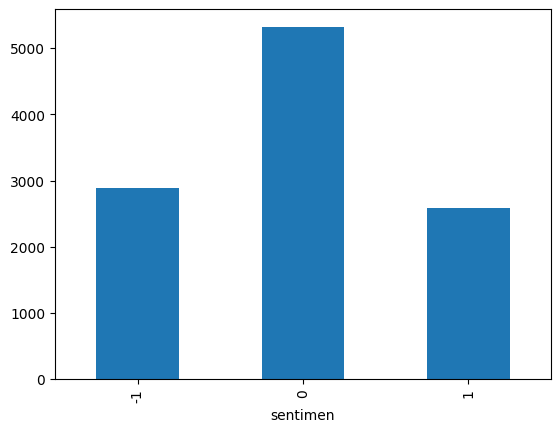

In [184]:
data_eda = data.copy()
data_eda.groupby('sentimen')['sentimen'].count().plot(kind='bar')
plt.show()

**Sebaran Jumlah kata pada setiap sentiment**

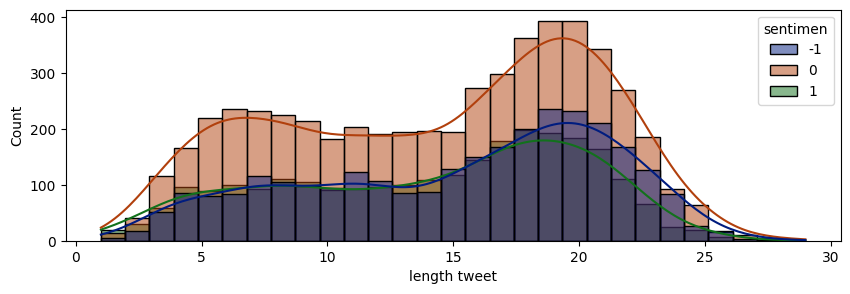

In [199]:
data_eda['length tweet']=data_eda['Tweet'].str.count(' ') + 1
fig, ax=plt.subplots(figsize=[10,3])
sns.histplot(data=data_eda, x = 'length tweet', hue='sentimen', kde=True, ax=ax, palette='dark')
plt.show()

<Axes: xlabel='sentimen', ylabel='length tweet'>

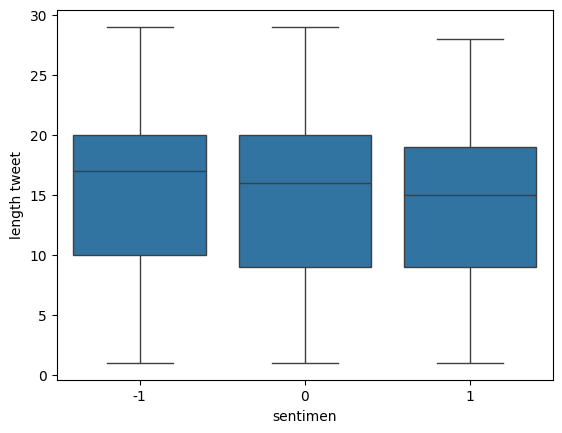

In [212]:
sns.boxplot(data_eda, x='sentimen', y ='length tweet')

Sebaran jumlah kata pada setiap sentiment tidak ada perbedaan yang menonjol. Artinya sulit membedakan sebuah sentimen berdasarkan jumlah katanya

In [129]:
def preprocessing_text(texts):
  texts = texts.lower() #make it lowercase
  texts = re.sub("@[a-z0-9_.]+"," ", texts) # Remove words starting with @
  texts = re.sub(r"http\S+", " ", texts) #remove link
  texts = re.sub(r"https\S+", " ", texts) #remove link
  texts = re.sub(r"www.\S+", " ", texts) #remove link
  tokens = word_tokenize(texts) # tokeenize
  texts = ' '.join([word for word in tokens if word not in stop_words]) #remove stop word
  texts = re.sub(r"#", "", texts)
  return texts

In [130]:
data_eda['text clean']=data_eda['Tweet'].apply(lambda x: preprocessing_text(x)) #cleaning word process

In [69]:
vectorize=TfidfVectorizer() #TFIDF initializer

Before using the word cloud, I first carried out tf-idf data with the hope that the words that appeared were only important words.

In [74]:
# create a function to create a word cloud via tf idf.
def plot_word(data, color = 'black', figsize=(7, 7), max_words=75):
    teks=vectorize.fit_transform(data)
    feature_names = vectorize.get_feature_names_out()
    dense = teks.todense()
    lst1 = dense.tolist()
    df = pd.DataFrame(lst1, columns=feature_names)
    wordcloud = WordCloud(stopwords=stop_words, # delete stopword
                      background_color=color,
                      width=1200,
                      height=800,
                      max_words=max_words,
                     ).generate_from_frequencies(df.T.sum(axis=1))
    plt.figure(1,figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

## Kata sering muncul

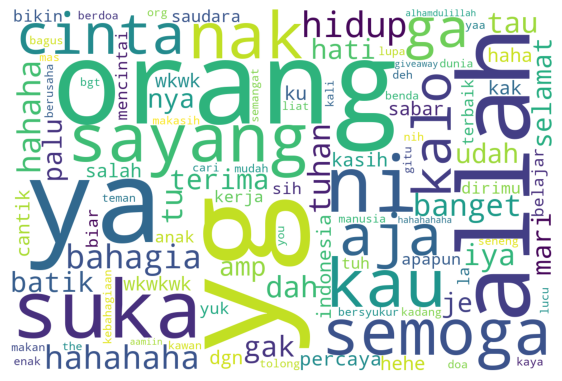

In [75]:
#show wordcloud sentimen positif
plot_word(data_eda[data_eda.sentimen==1]['text clean'], 'white', max_words=100)

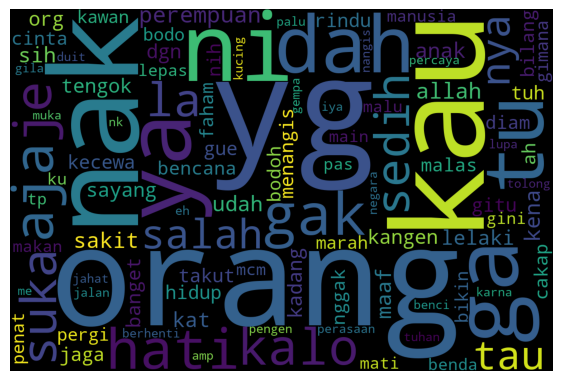

In [132]:
#show wordcloud sentimen negatif
plot_word(data_eda[data_eda.sentimen==-1]['text clean'], 'black', max_words=100)

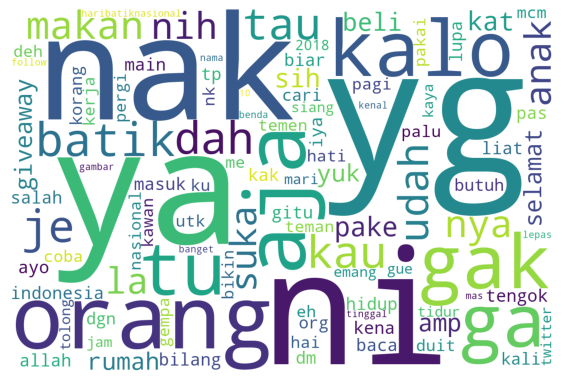

In [77]:
#show wordcloud sentimen netral
plot_word(data_eda[data_eda.sentimen==0]['text clean'], 'white', max_words=100)

## Preprocessing

In [134]:
max_feature=0
#membuat fungsi untuk case folding
def preprocessing_text(texts):
  global max_feature
  texts = texts.lower() #lowering text
  texts = texts.strip()
  texts = re.sub("@[a-z0-9_.]+"," ", texts) # Menghapus kata yang dimulai dengan @
  texts = re.sub(r"\\n"," ",texts) #menghapus enter text
  texts = re.sub(r"http\S+", " ", texts) #menghapus link
  texts = re.sub(r"www.\S+", " ", texts) #menghapus link
  texts = re.sub("[^a-z\s']"," ", texts) # menghapus selain alfabet
  tokens = word_tokenize(texts) # tokeenize
  if len(tokens)>max_feature:max_feature=len(tokens) # menghitung kata dengan jumlah kata terbanyak.
  texts = ' '.join([word for word in tokens if word not in stop_words]) #menghapus stop word
  return texts

## Membuat feature untuk model

In [135]:
data['feature']=data['Tweet'].apply(lambda x: preprocessing_text(x))

In [213]:
data['label'] = data['sentimen'].replace({1 : 2, 0:1, -1 : 0}) #label diambil dari data sentimen. Data diubah jadi 0,1 dan 2 agar lebih mudah di convert menggunakan one hot encoder

In [157]:
X_train, X_test, y_train, y_test = train_test_split(data.feature, data.label, test_size=0.2, random_state=0, stratify=data.label) # membagi dat menjadi train dan test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0) #membagi data test menjadi test dan validation data

In [158]:
#encoding data
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
y_val_ohe = to_categorical(y_val)

## Text Vectorizing

Counting the number of vocab...

In [159]:
#Hitung jumlah cocab
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
jml_vocab = len(Vectorize.vocabulary_.keys())
print('jumlah vocab adalah sebanyak '+str(jml_vocab))

jumlah vocab adalah sebanyak 16225


# Intializing Model

In [160]:
text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_feature,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(X_train)

## LSTM Model

In [161]:
embedding = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      )
model_lstm_1st = Sequential()
model_lstm_1st.add(text_vectorization)
model_lstm_1st.add(embedding)
model_lstm_1st.add(LSTM(max_feature))
model_lstm_1st.add(Dense(3,activation='softmax'))

model_lstm_1st.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_lstm_1st.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 29)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 29, 128)           2076800   
                                                                 
 lstm_2 (LSTM)               (None, 29)                18328     
                                                                 
 dense_4 (Dense)             (None, 3)                 90        
                                                                 
Total params: 2095218 (7.99 MB)
Trainable params: 2095218 (7.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


The model consists of 2 preprocessing layers, namely text vectorizing and embeding, 1 LSTM layer and 1 output layer with `softmax` activation. Because this model is intended for classification, the loss I use is `categorical_crossentropy` and the metric used is the `accuracy` metric. Accuracy was chosen because in this modeling, we are not focusing on one target.

The `GRU` model is also created the same as the LSTM model.

## GRU Model

In [162]:
embedding = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      )
model_gru_1st = Sequential()
model_gru_1st.add(text_vectorization)
model_gru_1st.add(embedding)
model_gru_1st.add(GRU(max_feature))
model_gru_1st.add(Dense(3,activation='softmax'))
model_gru_1st.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_gru_1st.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 29)                0         
 Vectorization)                                                  
                                                                 
 embedding_6 (Embedding)     (None, 29, 128)           2076800   
                                                                 
 gru_2 (GRU)                 (None, 29)                13833     
                                                                 
 dense_5 (Dense)             (None, 3)                 90        
                                                                 
Total params: 2090723 (7.98 MB)
Trainable params: 2090723 (7.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Train Model

## LSTM Model

In [163]:
csv_logger = CSVLogger('hist_lstm_1st.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/lstm_1st',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_lstm_1st = model_lstm_1st.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
432/432 [==============================] - 11s 21ms/step - loss: 1.0396 - accuracy: 0.4961 - val_loss: 1.0259 - val_accuracy: 0.4546
Epoch 2/50
432/432 [==============================] - 9s 20ms/step - loss: 0.8343 - accuracy: 0.6123 - val_loss: 1.0778 - val_accuracy: 0.5125
Epoch 3/50
432/432 [==============================] - 8s 19ms/step - loss: 0.4969 - accuracy: 0.8170 - val_loss: 1.2667 - val_accuracy: 0.4801
Epoch 4/50
432/432 [==============================] - 8s 19ms/step - loss: 0.2816 - accuracy: 0.9124 - val_loss: 1.5954 - val_accuracy: 0.4866
Epoch 5/50
432/432 [==============================] - 9s 21ms/step - loss: 0.1812 - accuracy: 0.9422 - val_loss: 1.8013 - val_accuracy: 0.4773
Epoch 6/50
432/432 [==============================] - 9s 21ms/step - loss: 0.1244 - accuracy: 0.9586 - val_loss: 2.1532 - val_accuracy: 0.4833
Epoch 7/50
432/432 [==============================] - 9s 21ms/step - loss: 0.1015 - accuracy: 0.9629 - val_loss: 2.5879 - val_accuracy: 0.449

<Axes: >

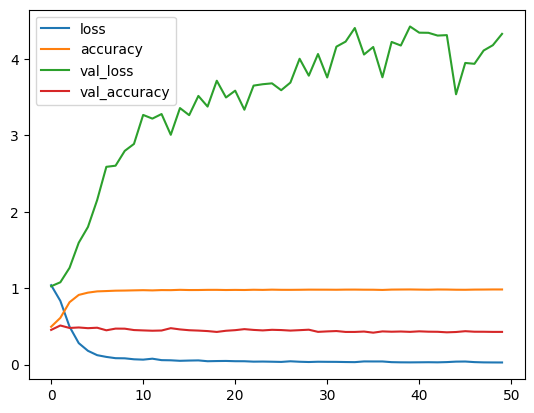

In [164]:
metrics = pd.DataFrame(hist_lstm_1st.history)
metrics.plot()

In [165]:
csv_logger = CSVLogger('hist_gru_1st.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/gru_1st',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_gru_1st = model_gru_1st.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50


432/432 [==============================] - 12s 24ms/step - loss: 1.0457 - accuracy: 0.4964 - val_loss: 1.0441 - val_accuracy: 0.4931
Epoch 2/50
432/432 [==============================] - 10s 22ms/step - loss: 1.0311 - accuracy: 0.5013 - val_loss: 1.0123 - val_accuracy: 0.4866
Epoch 3/50
432/432 [==============================] - 10s 23ms/step - loss: 0.7618 - accuracy: 0.6750 - val_loss: 0.9905 - val_accuracy: 0.5583
Epoch 4/50
432/432 [==============================] - 9s 22ms/step - loss: 0.3179 - accuracy: 0.8887 - val_loss: 1.2594 - val_accuracy: 0.5472
Epoch 5/50
432/432 [==============================] - 9s 22ms/step - loss: 0.1420 - accuracy: 0.9554 - val_loss: 1.4805 - val_accuracy: 0.5208
Epoch 6/50
432/432 [==============================] - 9s 22ms/step - loss: 0.0982 - accuracy: 0.9669 - val_loss: 1.8354 - val_accuracy: 0.4870
Epoch 7/50
432/432 [==============================] - 10s 22ms/step - loss: 0.0788 - accuracy: 0.9705 - val_loss: 1.8883 - val_accuracy: 0.5037
Epoch 

<Axes: >

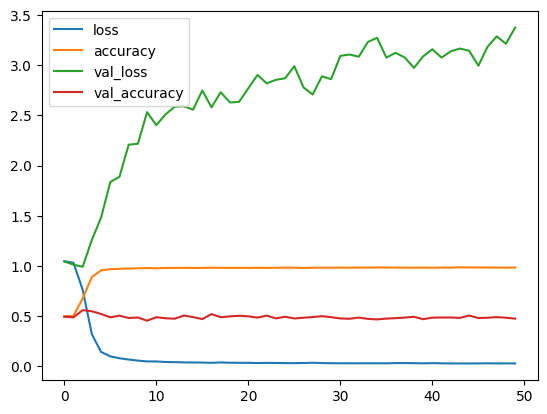

In [166]:
pd.DataFrame(hist_gru_1st.history).plot()

# Model Evaluation

## LSTM

In [167]:
pred_train=model_lstm_1st.predict(X_train)
pred_test=model_lstm_1st.predict(X_test)
pred_train_lbl=pred_train.argmax(axis=1)
pred_test_lbl=pred_test.argmax(axis=1)

68/68 [==============================] - 0s 3ms/step


In [168]:
print(classification_report(y_train, pred_train_lbl))
print(classification_report(y_test, pred_test_lbl))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1820
           1       0.98      0.99      0.99      3431
           2       1.00      0.97      0.98      1657

    accuracy                           0.98      6908
   macro avg       0.99      0.98      0.98      6908
weighted avg       0.98      0.98      0.98      6908

              precision    recall  f1-score   support

           0       0.32      0.75      0.45       577
           1       0.65      0.33      0.44      1065
           2       0.51      0.28      0.36       518

    accuracy                           0.43      2160
   macro avg       0.49      0.45      0.42      2160
weighted avg       0.53      0.43      0.42      2160



Model masih mengalami over-fit karena hasil train sangat tinggi sedangkan test sangat rendah

## GRU

In [169]:
pred_train=model_gru_1st.predict(X_train)
pred_test=model_gru_1st.predict(X_test)
pred_train_lbl=pred_train.argmax(axis=1)
pred_test_lbl=pred_test.argmax(axis=1)

68/68 [==============================] - 0s 3ms/step


In [170]:
print(classification_report(y_train, pred_train_lbl))
print(classification_report(y_test, pred_test_lbl))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1820
           1       0.98      0.99      0.99      3431
           2       0.99      0.97      0.98      1657

    accuracy                           0.99      6908
   macro avg       0.99      0.98      0.98      6908
weighted avg       0.99      0.99      0.99      6908

              precision    recall  f1-score   support

           0       0.35      0.63      0.45       577
           1       0.63      0.48      0.55      1065
           2       0.50      0.29      0.36       518

    accuracy                           0.47      2160
   macro avg       0.49      0.47      0.45      2160
weighted avg       0.52      0.47      0.48      2160



Begitu juga pada GRU model. Hasilnya masih over fit

# Penggunaan pada data tweeter

In [214]:
tweet_df['feature']= tweet_df['tweet'].apply(lambda x: preprocessing_text(x))
pred = model_gru_1st.predict(tweet_df['tweet'])
pred = np.argmax(pred, axis=1)
tweet_df['sentimen'] = pred

2/2 [==============================] - 0s 6ms/step


In [215]:
tweet_df

,username,user_id,tweet,sentimen,feature
0,Abdullah Ardhi,AbdullahArdhi,Kolaborasi IKN dan ACWA Power sinergi untuk ke...,0,kolaborasi ikn acwa power sinergi kehidupan hi...
1,Hyeji,bewithyiu,Uang pajak kita seharusnya bisa dialokasikan u...,0,uang pajak dialokasikan berguna bangun patung ...
2,wientaka,wientaxa,Replying to \n@tanyarlfes\nIkn itu cuma sekeda...,0,replying to ikn sekedar perwujudan ambisi poli...
3,rikai kanojo,wibungitis,They're building IKN like township \nkumparan\...,0,they 're building ikn like township kumparan m...
4,Olivia Alessandra,avocado_juice41,Replying to \n@tanyarlfes\nIKN ini menelan bia...,0,replying to ikn menelan biaya yg fantastis uda...
5,Gus,Baggiioooo,mmnita korut untk mngebom ikn dgn nuklirnya,0,mmnita korut untk mngebom ikn dgn nuklirnya
6,Abdullah Ardhi,AbdullahArdhi,Kolaborasi IKN dan ACWA Power sinergi untuk ke...,0,kolaborasi ikn acwa power sinergi kehidupan hi...
7,\nTanyarlfes,tanyarlfes,"Automated\ntanyarl sender kepooo, mau tau pand...",0,automated tanyarl sender kepooo tau pandangan ...
8,Norman_IKN,sinceApril1970,Replying to \n@Brady1892\n and \n@WeAreTheOver...,0,replying to and didn t brucey first spot the t...
9,\nTanyarlfes,tanyarlfes,"Automated\ntanyarl sender kepooo, mau tau pand...",0,automated tanyarl sender kepooo tau pandangan ...


# Buzzer analysis

<Axes: ylabel='followers'>

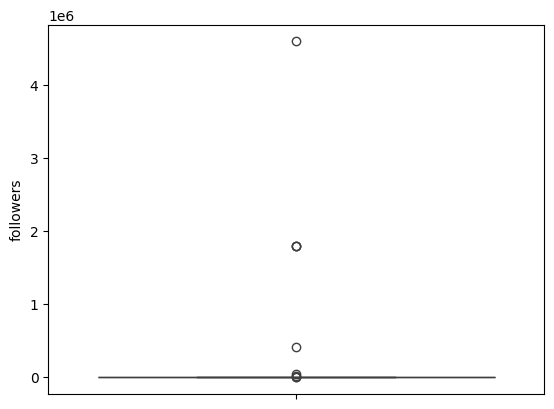

In [225]:
sns.boxplot(merged_data['followers'])

In [246]:
iqr = merged_data['followers'].quantile([0.25, 0.75]).diff()[0.75]
rata_rata = merged_data['followers'].median()

In [248]:
def caping_outlier(x, mean, iqr):
    min_value = mean - 1.5*iqr
    max_value = mean + 1.5*iqr
    # print(min_value)
    # print(max_value)
    if x< min_value:
        return min_value
    elif x> max_value:
        return max_value
    else:
        return x

In [250]:
merged_data['clean followers'] =  merged_data['followers'].apply(lambda x: caping_outlier(x, rata_rata, iqr))

<Axes: ylabel='clean followers'>

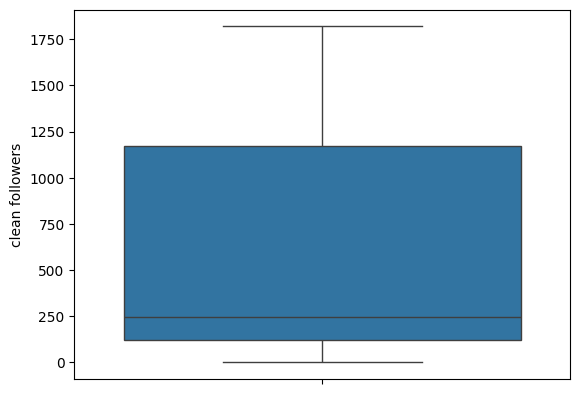

In [251]:
sns.boxplot(merged_data['clean followers'])

# Archive

In [171]:
jumlah_tweet_yang_ingin_diambil = 30
search =set()
jumlah_tweet_terambil=0
while jumlah_tweet_terambil < jumlah_tweet_yang_ingin_diambil:
    articles  = driver.find_elements(By.TAG_NAME, "article")
    search = search.union(set(articles))
    jumlah_tweet_terambil = len(search)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(5) 
    print(jumlah_tweet_terambil)


NameError: name 'driver' is not defined

In [ ]:
username_element = driver.find_element(By.CSS_SELECTOR, "span.css-1qaijid")
username = username_element.text if username_element else "Username not found"

# Menemukan link profil
div_elements_in_article = driver.find_elements(By.XPATH, "//div[@data-testid='User-Name']")
a_elements_in_article = driver.find_elements(By.XPATH, "//article//a")
profile_link_element = driver.find_elements(By.TAG_NAME, "article")

# print(profile_link_element.text)


In [ ]:
hover = div_elements_in_article[4].find_element(By.XPATH, ".//a")
# .get_attribute('Href')


In [ ]:
from selenium.webdriver.common.action_chains import ActionChains
actions = ActionChains(driver)
actions.move_to_element(hover).perform()


# Sekarang Anda dapat melakukan apapun yang Anda inginkan dengan elemen yang muncul setelah hover,
# seperti mengambil teks atau atributnya
print("Text of element after hover:", element_after_hover.text)

Text of element after hover: Ikuti
𐙚hisa
@Amseer_
who am i? ho ho ho who knows
245 Mengikuti
183 Pengikut


In [ ]:
[cek.get_attribute("href") for cek in div_elements_in_article]

[None, None, None, None, None, None, None]

In [ ]:
a_elements_in_article[4].get_attribute('Href')

'https://twitter.com/CGV_ID/status/1787836318829174954'

In [ ]:
[t.text for t in profile_link_element]

['CGV Cinemas\n@CGV_ID\nIkuti\nCoba sini mana yang sudah nanyain. Kamu salah satunya bukan?\n\nTemukan jawabannya besok di media sosial CGV Cinemas Indonesia ya~\n\n#SemuaSerudiCGV\n0:01 / 0:13\n8.26 PM · 7 Mei 2024\n·\n79,8 rb\n Tayangan\n195\n1 rb\n1 rb\n80',
 'blueberry\n@bevurry\n·\n7 Mei\nAAAAAAAAAAAAAAA SIP SY CATAT\n3\n3 rb',
 'sho\n@_shoshine\n·\n7 Mei\npls adain merch tp ga hanya utk yg fan screening, collectable ticket jg gpp\n14\n1 rb',
 'debs ༄\n@deboratobing\n·\n7 Mei\nLet’s goooooooo\nGIF\n11\n1 rb',
 '𐙚hisa\n@Amseer_\n·\n7 Mei\nknp cuma cgv???? gada cgv di tempatku\n1\n1 rb',
 'Hero Wars\n@HeroWarsWeb\nDominion awaits, come be a hero! Like the man said: heroes get remembered, but legends never die. Step up to the plate in Hero Wars and start swinging\n0:00 / 2:00\nDari hero-wars.com\n7\n17\n40\n276 rb\nDipromosikan']

In [ ]:
for tweet in new_tweets:
    print(tweet.text)

# Tutup browser
driver.quit()


Nos eliminó un PSG que lo echó el jodido Borussia Dortmund en semis. Era la final de Champions mas accesible del siglo para el Barça.
 La célébration du parcage de Dortmund avec Marco Reus qui vit sa dernière saison en jaune 

#PSGBVB #BVB
Pertandingan leg ke-2. Jumlah shot:
PSG 30-7 Dortmund

Skor akhir pertandingan:
PSG 0-1 Dortmund

Borussia Dortmund melaju ke final, unggul agregat 2-0! 
Tastes like fine wine 
...and breathe 
Yo a la vida solo le pido que este tío se vaya del Dortmund levantando la Champions.
A festa no balneário do Dortmund 
No me despierten mas.
